# Logistic Regression to aid in Feature Selection 

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_validate


# Neural Network 
from sklearn.feature_selection import RFECV    # for feature selection 

In [377]:
# LOADING IN TRAINING DATA 
df = pd.read_csv("data/train.csv")
# Note that y contains binary label indicating if mid_price goes up 
# in next timestep (y = 1) or not (0). Output probability of mid_price
# going up. 
df.columns = list(df.columns.values)
df_test = pd.read_csv("data/test.csv")
df_test.columns = list(df_test.columns.values)

In [378]:
# Let's add the following indicators to the train/ test set and see how far we can
# push logistic regression. 


# ADD (bid volumes / ask volumes) ratio  TO TRAIN AND TEST 
# indicator - ratio of all bid volumes to all ask volumes
df_test = df_test.assign(bid_ask_ratio_all = \
                        lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                                  (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))

# indicator - ratio of all bid volumes to all ask volumes
df = df.assign(bid_ask_ratio_all = \
                        lambda x: (x.bid1vol+x.bid2vol+x.bid3vol+x.bid4vol+x.bid5vol) / \
                                  (x.ask1vol+x.ask2vol+x.ask3vol+x.ask4vol+x.ask5vol))


# Add (best bid volume / best ask volume) TO TRAIN AND TEST 
# indicator - ratio of best bid (bid1) volume to best ask (ask1) volume
df_test = df_test.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)
df = df.assign(bid_ask_ratio_best = lambda x: x.bid1vol / x.ask1vol)


# indicator - difference between the price of most recent order and average of best bid and best ask (mid)
df_test = df_test.assign(diff_price = lambda x: (x.last_price) - (x.mid))
df = df.assign(diff_price = lambda x: (x.last_price) - (x.mid))

# indicator - difference between best bid price and best ask price
df_test = df_test.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))
df = df.assign(diff_best_bid_ask = lambda x: (x.bid1) - (x.ask1))

In [379]:
df.head()

,id,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,...,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,bid_ask_ratio_all,bid_ask_ratio_best,diff_price,diff_best_bid_ask
0,0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,...,6,1,1,10,2,1,1.750000,1.333333,-0.2,-0.4
1,1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,...,1,4,4,1,13,0,1.347826,7.000000,-0.6,-0.8
2,2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,...,1,16,10,4,9,0,1.025000,3.000000,-0.3,-1.0
3,3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,...,2,7,1,2,11,1,1.782609,5.000000,0.4,-0.8
4,4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,...,1,3,1,11,15,1,1.096774,14.000000,0.1,-0.6


In [380]:
df_num_corr = df.corr()['y'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr) > 0.01].sort_values(ascending=False)
print("There are {} features decently correlated w/ mid price:\n{}".format(len(golden_features_list), golden_features_list))


There are 25 features decently correlated w/ mid price:
y                       1.000000
bid_ask_ratio_best      0.149051
diff_price              0.129447
bid1vol                 0.086308
bid_ask_ratio_all       0.086050
transacted_qty          0.056453
closed_position_qty     0.046323
opened_position_qty     0.032599
bid2vol                 0.029456
last_price              0.019276
ask5                    0.019128
ask4                    0.019119
ask3                    0.019109
ask2                    0.019092
bid4                    0.018991
bid3                    0.018990
bid5                    0.018989
bid2                    0.018984
ask1                    0.018978
mid                     0.018940
bid1                    0.018901
id                      0.014694
d_open_interest        -0.015503
ask2vol                -0.025560
ask1vol                -0.126212
Name: y, dtype: float64


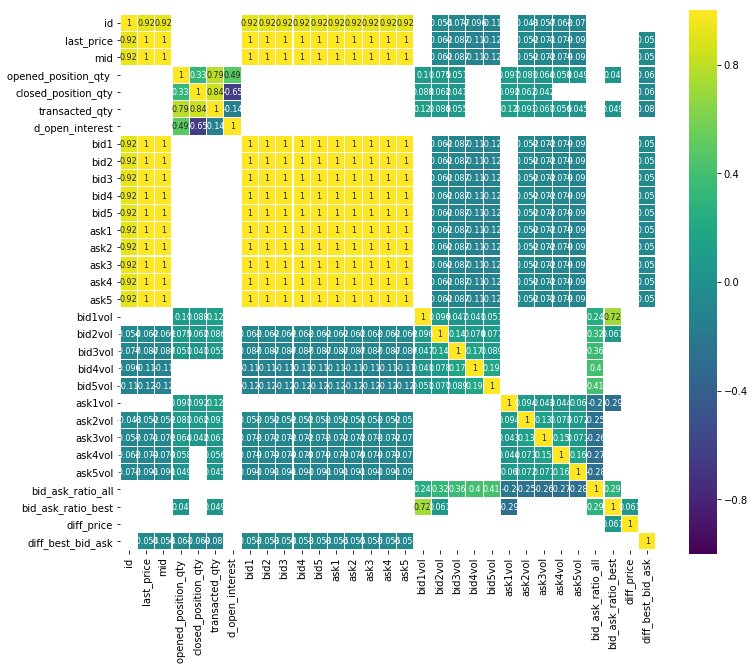

In [339]:
corr = df.drop('y', axis=1).corr() # We already examined y correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.04) | (corr <= -0.04)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

Analyzing the correlation above: It looks like both mid_price and last_price are highly correlated with 
one another, and both are perfectly correlated [bid1, bid2,  ... bid5,ask1, ... ask5], which indicates that
we may want to drop many or all of [bid1, bid2,  ... bid5,ask1, ... ask5] and one of [mid_price, last_price]
to avoid extreme multicollinearity in a linear model. For non-linear, this is not so clear. 

In [351]:
# Dropping the nuisance columns 
df.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)
df_test.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)

In [382]:
# Filling NaNs
nan_values = {'opened_position_qty ': (df['transacted_qty'] + df['d_open_interest']) / 2 , 
              'closed_position_qty': (df['transacted_qty'] - df['d_open_interest']) / 2}

nan_values_test = {'opened_position_qty ': (df_test['transacted_qty'] + df_test['d_open_interest']) / 2 , 
              'closed_position_qty': (df_test['transacted_qty'] - df_test['d_open_interest']) / 2}

df = df.fillna(value=nan_values)
df_test = df_test.fillna(value=nan_values_test)

# RFECV with estimator as logistic regression does not seem to work very well at all... 

In [384]:
# Split into training X, y
last_idx = len(df.columns) - 1
y_train = df.y
#y_train = y_train.astype(int)
X = df[df.columns[:-1]]

col_titles = X.columns 

X = np.array(X)
y_train = np.array(y_train)


# HANDLING IDs FOR TRAINING 
X_ids = X[:, 0]  # Vector of id's 
X = X[:, 1:]
# HANDLING IDs for TEST
X_test_ids = X_test[:, 0]
X_test = X_test[:, 1:]


# Normalize test set features using training set stats
for j in range(0,len(X_test[0])):
    X_std = np.std(X[:, j])
    X_test[:, j] -= np.mean(X[:, j])
    X_test[:, j] *= (1 / X_std)

# Normalize training set features 
for j in range(0,len(X[0])):
    X_std = np.std(X[:, j])
    X[:, j] -= np.mean(X[:, j])
    X[:, j] *= (1 / X_std)

In [387]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
selector = RFECV(estimator=LogisticRegression(solver='lbfgs', max_iter=200), step=1, \
              cv=5, scoring='roc_auc')
selector.fit(X, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=200,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='roc_auc', step=1,
      verbose=0)

In [388]:
print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(col_titles, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

The optimal number of features is 1
The selected features are:
['ask5vol']


Optimal number of features: 1


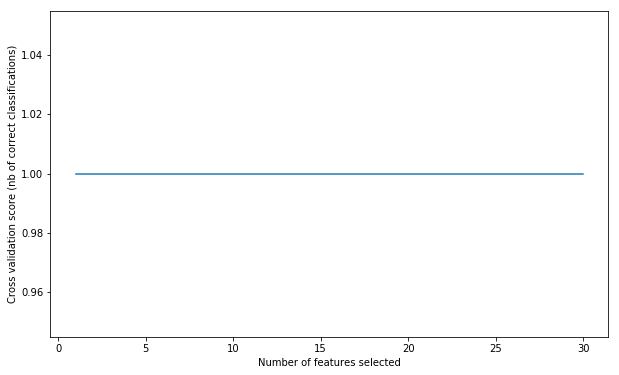

In [391]:

#X = df[df.columns[:-1]]
#y_train = df[df.columns[last_idx]]
#X = np.array(X)
#y_train = np.array(y_train)
#X_test = df_test
#X_test = np.array(X_test)
print("Optimal number of features: %d" % selector.n_features_)
#print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [392]:
# Dropping the nuisance columns 
df.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)
df_test.drop(columns=['closed_position_qty', 'opened_position_qty '], inplace=True)

# Let's drop [bid2, ... bid5, ask2, ... ask5] columns due to heavy correlation 
df.drop(columns=['bid1','bid2', 'bid3', 'bid4', 'bid5', 'ask1','ask2', 'ask3', \
                 'ask4', 'ask5'], inplace=True)
df_test.drop(columns=['bid1', 'bid2', 'bid3', 'bid4', 'bid5', 'ask1','ask2', 'ask3', \
                 'ask4', 'ask5'], inplace=True)

# the bid and ask vols seem to be not horribly correlated so let's leave em 

In [393]:
# Separating into X and y training 
last_idx = len(df.columns) - 1
X = df[df.columns[:-1]]
#y_train = df[df.columns[last_idx]]
y_train = df.y
X = np.array(X)
y_train = np.array(y_train)
X_test = df_test
X_test = np.array(X_test)


In [394]:
pd.isna(X).any()

False

In [395]:
pd.isna(X_test).any()

False

In [396]:
# HANDLING IDs FOR TRAINING 
X_ids = X[:, 0]  # Vector of id's 
X = X[:, 1:]
# HANDLING IDs for TEST
X_test_ids = X_test[:, 0]
X_test = X_test[:, 1:]

In [397]:
# Normalize test set features using training set stats
for j in range(0,len(X_test[0])):
    X_std = np.std(X[:, j])
    X_test[:, j] -= np.mean(X[:, j])
    X_test[:, j] *= (1 / X_std)

# Normalize training set features 
for j in range(0,len(X[0])):
    X_std = np.std(X[:, j])
    X[:, j] -= np.mean(X[:, j])
    X[:, j] *= (1 / X_std)

In [308]:
np.isnan(X_test).any()

False

In [309]:
np.isnan(X).any()
y_train.astype(int)

array([1, 0, 0, ..., 0, 0, 0])

In [398]:
len(y_train)

592380

# Logistic Regression w/ L2 Regularization 

In [399]:
# Let's try logistic regression for different lambda = 0.00001,
# 0.00005, 0.00025, 61, 035.15625
lam = 0.0005 # Penalizing to take care of some strong correlation between features  
# C is inverse of regularization strength 

#base = np.repeat(5, 5)
#power = np.arange(0, 5)
#lambdas = np.power(base, power)
#final_lambdas = 0.00001 * lambdas

# The C's (inv regularization strength) range from 1e-5 ... 1e5
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y_train)
#clf = LogisticRegression(penalty='l2', C=(1/lam)).fit(X, y_trai )
y_pred = clf.predict_proba(X)
y_pred = y_pred[:,1]    # Grabbing probabililities of being in class 1

In [400]:
# Performance metric AUC (Area under the Receivor Operating Curve), you want an AUC near 1 
roc_auc_score(y_train, y_pred)
#X = preprocessing.normalize(X) # Normalizing all observation vectors to have length of 1

1.0

In [313]:
# Predicting on test set 
y_pred_test = clf.predict_proba(X_test)
y_pred_test = y_pred_test[:,1]  

In [314]:
X_test_ids = X_test_ids.astype(int)

In [315]:
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

#clf_test = RandomForestClassifier(max_depth=5, min_samples_split=2, 
                                 # random_state=0, n_estimators=10, 
                                 # max_features='sqrt', criterion='gini')

results = cross_validate(clf, X, y_pred, cv=5, scoring=list(scoring.values()), 
                         return_train_score=False)
    
print('\nK-fold cross-validation results: ')
for sc in range(len(scoring)):
    print(clf.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc], -results['test_%s' % list(scoring.values())[sc]].mean()
    if list(scoring.values())[sc]=='neg_log_loss' 
    else results['test_%s' % list(scoring.values())[sc]].mean(), 
        results['test_%s' % list(scoring.values())[sc]].std()))


K-fold cross-validation results: 
LogisticRegressionCV average accuracy: nan (+/-nan)
LogisticRegressionCV average log_loss: nan (+/-nan)
LogisticRegressionCV average auc: nan (+/-nan)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unknown label type: 'continuous'

  FitFailedWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition f

# Outputting results to submission csv 

In [316]:
predictions = {'id': X_test_ids, 'Predicted': y_pred_test}
df_output = pd.DataFrame(predictions, columns=['id', 'Predicted'])
df_output.set_index('id')

,Predicted
id,
592380,0.999689
592381,0.954738
592382,0.998792
592383,0.925036
592384,0.918534
592385,0.885811
592386,0.990727
592387,0.999926
592388,0.612778


In [186]:
#df_output.dtypes
#df_output.astype({'id': 'int32'}, inplace=True).dtypes

id             int32
Predicted    float64
dtype: object

In [187]:
df_output.head()

,id,Predicted
0,592380.0,0.663596
1,592381.0,0.423627
2,592382.0,0.353316
3,592383.0,0.525968
4,592384.0,0.465634


In [317]:
df_output.to_csv('logis_regularized_1.csv', index=None)

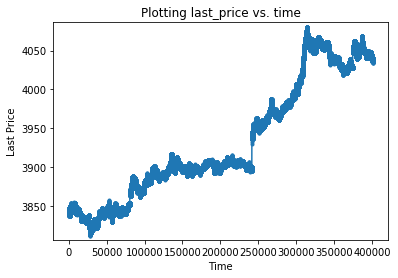

In [15]:
fig = plt.figure()
plt.title('Plotting last_price vs. time')
plt.xlabel('Time')
plt.ylabel('Last Price')
plt.margins(y=0.02)

plt.plot(train_data["id"], train_data["last_price"], marker = '.', linewidth = 1.5)

In [ ]:
# Let's try a neural net (non-linear model that is a composition of linear models)

In [ ]:
# Note that the majority of the time, the mid price does not go up. Also note that on average,
# the maximum likelihood model (e.g. Regression) gives higher probabilites to positive examples
# and lower probabilities to negative examples. 

In [ ]:
# Let's do logistic regression and random forest blending 

In [ ]:
# Let's drop [bid1, ask1] as well to see if anything changes drastically. 
df.drop(columns=['bid1','ask1'], inplace=True)
df_test.drop(columns=['bid1', 'ask1'], inplace=True)

In [ ]:
# Separating into X and y training 
last_idx = len(df.columns) - 1
X = df[df.columns[:-1]]
y_train = df[df.columns[last_idx]]
X = np.array(X)
y_train = np.array(y_train)
X_test = df_test
X_test = np.array(X_test)